In [1]:
import pycigar
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
from pycigar.utils.logging import logger
from pycigar.utils.output import plot_new

from ray.tune.registry import register_env

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import json
from pathlib import Path
from ray.rllib.models.tf.tf_action_dist import DiagGaussian
from ray.rllib.models.catalog import ModelCatalog
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## Env config

In [2]:
def adjust_defaults(sim_params):
    for node in sim_params['scenario_config']['nodes']:
        for d in node['devices']:
            d['adversary_controller'] = 'unbalanced_fixed_controller'
            name = d['name']
#             c = np.array(d['custom_configs']['default_control_setting'])
#             if name.endswith('a'):
#                 c = c - 0.02
#             elif name.endswith('b'):
#                 c = c + 0.02
#             elif name.endswith('c'):
#                 c = c - 0.01
#            d['custom_configs']['default_control_setting'] = c
    
    sim_params['simulation_config']['custom_configs']['solution_control_mode'] = 2

            
def set_hack_percent(sim_params, hack=0.45):
    for node in sim_params['scenario_config']['nodes']:
        for d in node['devices']:
            d['hack'] = [250, hack, 500]
    
def get_config(env_name='CentralControlPhaseSpecificContinuousPVInverterEnv'):
    pycigar_params = {'exp_tag': 'cooperative_multiagent_ppo',
                      'env_name': env_name,
                      'simulator': 'opendss'}
    create_env, env_name = make_create_env(pycigar_params, version=0)
    register_env(env_name, create_env)

    misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/misc_inputs.csv"
    dss_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/ieee37.dss"
    load_solar_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/load_solar_data.csv"
    breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/breakpoints.csv"
    sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path)
    
    eval_start = 100
    sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]
    sim_params['scenario_config']['multi_config'] = False
    del sim_params['attack_randomization']
    adjust_defaults(sim_params)
    
    return create_env, sim_params

## Util: eval policy checkpoint

In [3]:
def eval_baseline(eval_start=100, hack=0.45):
    create_env, sim_params = get_config('CentralControlPhaseSpecificContinuousPVInverterEnv')
    set_hack_percent(sim_params, hack)
    result_dict = {'stds': []}
    
    sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]
    test_env = create_env(sim_params)

    done = False
    obs = test_env.reset()
    obs = obs.tolist()
    while not done:
        obs, r, done, _ = test_env.step(np.array([0, 0, 0]))
        obs = obs.tolist()

    Logger = logger()
    f = plot_new(Logger.log_dict, Logger.custom_metrics, None, unbalance=True)
    result_dict['figure'] = f
    plt.close(f)
    inv = [k for k in Logger.log_dict if k.startswith('inverter_s701') or k.startswith('inverter_s728')][0]

    result_dict['u_sum'] = sum(Logger.log_dict[inv]['u'])
    return result_dict

In [4]:
def eval_dir_discrete(best_dir, eval_start=100, hack=0.45):
    create_env, sim_params = get_config('CentralControlPhaseSpecificPVInverterEnv')
    set_hack_percent(sim_params, hack)
    result_dict = {'stds': [], 'dir': best_dir.parent}
    try:
        params = json.loads((best_dir.parent / 'params.json').read_text())['config']['evaluation_config']['env_config']
    except Exception:
        params = json.loads((best_dir.parent.parent / 'params.json').read_text())['config']['evaluation_config']['env_config']

    params['scenario_config'] = sim_params['scenario_config']
    sim_params['M'] = params['M']
    sim_params['N'] = params['N']
    sim_params['P'] = params['P']
    
    sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]

    infos = json.loads((best_dir / 'info.json').read_text())
    result_dict['epoch'] = infos['epoch']

    test_env = create_env(sim_params)
    action_dist, _ = ModelCatalog.get_action_dist(
        test_env.action_space, config={}, dist_type=None, framework='tf')
    #assert isinstance(action_dist, DiagGaussian.__class__), 'For now only continuous gaussian action are supported'
    print('a')
    done = False
    obs = test_env.reset()
    obs = obs.tolist()
    while not done:
        out = infer(
            prev_reward=tf.constant([0.], tf.float32),
            observations=tf.constant([obs], tf.float32),
            is_training=tf.constant(False),
            seq_lens=tf.constant([0], tf.int32),
            prev_action=tf.constant([0], tf.int64)
        )['action_dist_inputs'].numpy()
        dist = action_dist(inputs=out, model=None)
        act = dist.deterministic_sample().numpy().batches

        obs, r, done, _ = test_env.step(act)
        obs = obs.tolist()

    Logger = logger()
    f = plot_new(Logger.log_dict, Logger.custom_metrics, infos['epoch'], unbalance=True)
    result_dict['figure'] = f
    plt.close(f)

    inv = [k for k in Logger.log_dict if k.startswith('inverter_s701') or k.startswith('inverter_s728')][0]

    result_dict['u_sum'] = sum(Logger.log_dict[inv]['u'])
    return result_dict

In [15]:
def eval_dir_continuous(best_dir, eval_start=100, hack=0.45):
    create_env, sim_params = get_config('CentralControlPhaseSpecificContinuousPVInverterEnv')
    set_hack_percent(sim_params, hack)
    result_dict = {'stds': [], 'dir': best_dir.parent}
    try:
        params = json.loads((best_dir.parent / 'params.json').read_text())['config']['evaluation_config']['env_config']
    except Exception:
        params = json.loads((best_dir.parent.parent / 'params.json').read_text())['config']['evaluation_config']['env_config']

    params['scenario_config'] = sim_params['scenario_config']
    sim_params['M'] = params['M']
    sim_params['N'] = params['N']
    sim_params['P'] = params['P']
    
    sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]

    infos = json.loads((best_dir / 'info.json').read_text())
    result_dict['epoch'] = infos['epoch']


    test_env = create_env(sim_params)
    action_dist, _ = ModelCatalog.get_action_dist(
        test_env.action_space, config={}, dist_type=None, framework='tf')
    assert isinstance(action_dist, DiagGaussian.__class__), 'For now only continuous gaussian action are supported'

    print('a')
    done = False
    obs = test_env.reset()
    obs = obs.tolist()
    while not done:
        out = infer(
            prev_reward=tf.constant([0.], tf.float32),
            observations=tf.constant([obs], tf.float32),
            is_training=tf.constant(False),
            seq_lens=tf.constant([0], tf.int32),
            prev_action=tf.constant([0], tf.float32)
        )['action_dist_inputs'].numpy()
        dist = action_dist(inputs=out, model=None)
        act, std = dist.deterministic_sample().numpy().flatten(), dist.std.numpy().flatten()
        result_dict['stds'].append(std)

        obs, r, done, _ = test_env.step(act)
        obs = obs.tolist()

    Logger = logger()
    f = plot_new(Logger.log_dict, Logger.custom_metrics, infos['epoch'], unbalance=True)
    result_dict['figure'] = f
    inv = [k for k in Logger.log_dict if k.startswith('inverter_s701') or k.startswith('inverter_s728')][0]

    result_dict['u_sum'] = sum(Logger.log_dict[inv]['u'])
    return result_dict

In [6]:
def eval_dir_multi(best_dir, eval_start=100, hack=0.45):
    create_env, sim_params = get_config('PhaseSpecificContinuousMultiEnv')
    set_hack_percent(sim_params, hack)
    result_dict = {'dir': best_dir.parent}
    params = json.loads((best_dir.parent / 'params.json').read_text())['config']['evaluation_config']['env_config']
    params['scenario_config'] = sim_params['scenario_config']
    sim_params['M'] = params['M']
    sim_params['N'] = params['N']
    sim_params['P'] = params['P']
    
    sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]

    infos = json.loads((best_dir / 'info.json').read_text())
    result_dict['epoch'] = infos['epoch']

    test_env = create_env(sim_params)
    action_dist, _ = ModelCatalog.get_action_dist(
        test_env.action_space, config={}, dist_type=None, framework='tf')
    assert isinstance(action_dist, DiagGaussian.__class__), 'For now only continuous gaussian action are supported'
    done = {'__all__': False}
    obs = test_env.reset()
    while not done['__all__']:        
        act = {}
        for k in obs:
            if k.endswith('a'):
                infer = infer_a
            elif k.endswith('b'):
                infer = infer_b
            elif k.endswith('c'):
                infer = infer_c
            else:
                act[k] = np.array([0])
                continue
            out = infer(
                prev_reward=tf.constant([0.], tf.float32),
                observations=tf.constant([obs[k]], tf.float32),
                is_training=tf.constant(False),
                seq_lens=tf.constant([0], tf.int32),
                prev_action=tf.constant([0], tf.float32)
            )['action_dist_inputs'].numpy()
            dist = action_dist(inputs=out, model=None)
            a, std = dist.deterministic_sample().numpy().flatten(), dist.std.numpy().flatten()
            act[k] = a
                
        obs, r, done, _ = test_env.step(act)

    Logger = logger()
    f = plot_new(Logger.log_dict, Logger.custom_metrics, infos['epoch'], unbalance=True)
    result_dict['figure'] = f
    plt.close(f)
    inv = [k for k in Logger.log_dict if k.startswith('inverter_s701') or k.startswith('inverter_s728')][0]

    result_dict['u_sum'] = sum(Logger.log_dict[inv]['u'])
    return result_dict

## Continuous gridearch

In [7]:
# %matplotlib agg
# %matplotlib agg

# SAVE_PATH = 
# results = []
# for best_dir in Path(SAVE_PATH).expanduser().rglob('best/'):
#     print(f'Evaluating {best_dir.parent}')
#     result_dict = eval_dir(best_dir);
#     results.append(result_dict)


In [8]:
# print([d['u_sum'] for d in results])
# print(np.argmin([d['u_sum'] for d in results]))
# results[np.argmin([d['u_sum'] for d in results])]['dir']

In [9]:
import pandas as pd
import pickle
from multiprocessing import Pool, Queue
import itertools
from functools import partial

start_times = list(range(0, 14000, 1800))
hacks = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
times_hack_product = list(itertools.product(start_times, hacks))

## Baseline

In [ ]:
%matplotlib agg
%matplotlib agg

baseline_u = pd.DataFrame(index=start_times, columns=hacks)

with Pool(2) as p:
    res = p.starmap(eval_baseline, times_hack_product)
    
for r, (eval_start, hack) in zip(res, times_hack_product):
    baseline_u.at[eval_start, hack] = r['u_sum']
    
del res

with open('baseline.pickle', 'wb') as f:
    pickle.dump(baseline_u, f)

In [ ]:
baseline_u

## Continuous

In [ ]:
%matplotlib agg
%matplotlib agg

best_dir = Path('/home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_0_M=1000,M=1000,N=50,P=100_2020-06-23_08-35-33sqg4e1f9/best')
cont_u = pd.DataFrame(index=start_times, columns=hacks)

infos = json.loads((best_dir / 'info.json').read_text())
policy = tf.saved_model.load(str(best_dir / f'policy_{infos["epoch"]}'))
infer = policy.signatures['serving_default']

print('starting')
with Pool(1) as p:
    res = p.starmap(partial(eval_dir_continuous, best_dir), times_hack_product)
    
for r, (eval_start, hack) in zip(res, times_hack_product):
    cont_u.at[eval_start, hack] = r

del res
    
with open('cont.pickle', 'wb') as f:
    pickle.dump(cont_u, f)

starting
a
a
a
a


## Discrete

In [ ]:
%matplotlib agg
%matplotlib agg

best_dir = Path('/home/alexandre/dev/LBL/lrc/results_discrete/best')
discrete_u = pd.DataFrame(index=start_times, columns=hacks)

policy = tf.saved_model.load(str(best_dir / f'policy'))
infer = policy.signatures['serving_default']
    
with Pool(2) as p:
    res = p.starmap(partial(eval_dir_discrete, best_dir), times_hack_product)
    
for r, (eval_start, hack) in zip(res, times_hack_product):
    discrete_u.at[eval_start, hack] = r

del res

with open('discrete.pickle', 'wb') as f:
    pickle.dump(discrete_u, f)

## Multi continuous

In [ ]:
%matplotlib agg
%matplotlib agg

multi_u = pd.DataFrame(index=start_times, columns=hacks)
best_dir = Path('~/dev/LBL/lrc/results_multiagent_2/best').expanduser()

policy_a = tf.saved_model.load(str(best_dir / 'policy/phase_a'))
infer_a = policy_a.signatures['serving_default']
policy_b = tf.saved_model.load(str(best_dir / 'policy/phase_b'))
infer_b = policy_b.signatures['serving_default']
policy_c = tf.saved_model.load(str(best_dir / 'policy/phase_c'))
infer_c = policy_c.signatures['serving_default']
    
with Pool(2) as p:
    res = p.starmap(partial(eval_dir_multi, best_dir), times_hack_product)
    
for r, (eval_start, hack) in zip(res, times_hack_product):
    multi_u.at[eval_start, hack] = r

del res
   
with open('multi.pickle', 'wb') as f:
    pickle.dump(multi_u, f)

In [ ]:
%matplotlib agg
%matplotlib agg

multi_new_u = pd.DataFrame(index=start_times, columns=hacks)
best_dir = Path('~/dev/LBL/lrc/results_multiagent_new_r/best').expanduser()
        
with Pool(2) as p:
    res = p.starmap(partial(eval_dir_multi, best_dir), times_hack_product)
    
for r, (eval_start, hack) in zip(res, times_hack_product):
    multi_new_u.at[eval_start, hack] = r

del res
        
with open('multi_new_r.pickle', 'wb') as f:
    pickle.dump(multi_new_u, f)

In [ ]:
%matplotlib inline
import pandas as pd
import pickle

with open("baseline.pickle", "rb") as f:
    baseline_u = pickle.load(f)
with open("multi.pickle", "rb") as f:
    multi_u = pickle.load(f) - baseline_u
with open("multi_new_r.pickle", "rb") as f:
    multi_new_r_u = pickle.load(f) - baseline_u
with open("cont.pickle", "rb") as f:
    cont_u = pickle.load(f) - baseline_u
with open("discrete.pickle", "rb") as f:
    discrete_u = pickle.load(f) - baseline_u


times_index_str = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30']
# discrete_u = [6.0444, 5.1379, 4.7188, 5.6285, 6.3616, 6.2202, 6.6645, 6.0929]


f, axs = plt.subplots(ncols=3, nrows=3, figsize=(30, 30))
axs = np.array(axs).flatten()
for i, h in enumerate(hacks):
    axs[i].plot(times_index_str, discrete_u.loc[:, h].to_numpy(), marker='s', lw=2, ls='-.', markersize=15, label='central discrete')
    axs[i].plot(times_index_str, cont_u.loc[:, h].to_numpy(), marker='s', lw=2, ls='-.', markersize=15, label='central continuous')
    axs[i].plot(times_index_str, multi_u.loc[:, h].to_numpy(), marker='D', lw=2, ls='-.', markersize=15, label='multiagent continuous')
    axs[i].plot(times_index_str, multi_new_r_u.loc[:, h].to_numpy(), marker='D', lw=2, ls='-.', markersize=15, label='multiagent continuous (new r)')

    axs[i].plot(times_index_str, (baseline_u - baseline_u).loc[:, h].to_numpy(), marker='', c='r', lw=6, alpha=0.5, markersize=15, label='baseline (no action)')

    axs[i].set_title(f'hack {h}', fontsize=25)
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_xlabel('day time', fontsize=15)
    axs[i].set_ylabel('unbalance diff to baseline', fontsize=15);
    #axs[i].set_ylim([-8.5,1])

axs[0].legend(prop={'size': 25}, loc=(0, 1.05), frameon=False, ncol=2, columnspacing=2.5)


In [19]:
%matplotlib agg
%matplotlib agg

best_dir = Path('/home/alexandre/dev/LBL/lrc/results_discrete/best')
discrete_u = pd.DataFrame(index=start_times, columns=hacks)

policy = tf.saved_model.load(str(best_dir / f'policy'))
infer = policy.signatures['serving_default']
    
res = eval_dir_discrete(best_dir, 0, 0.45)
res['figure']

a


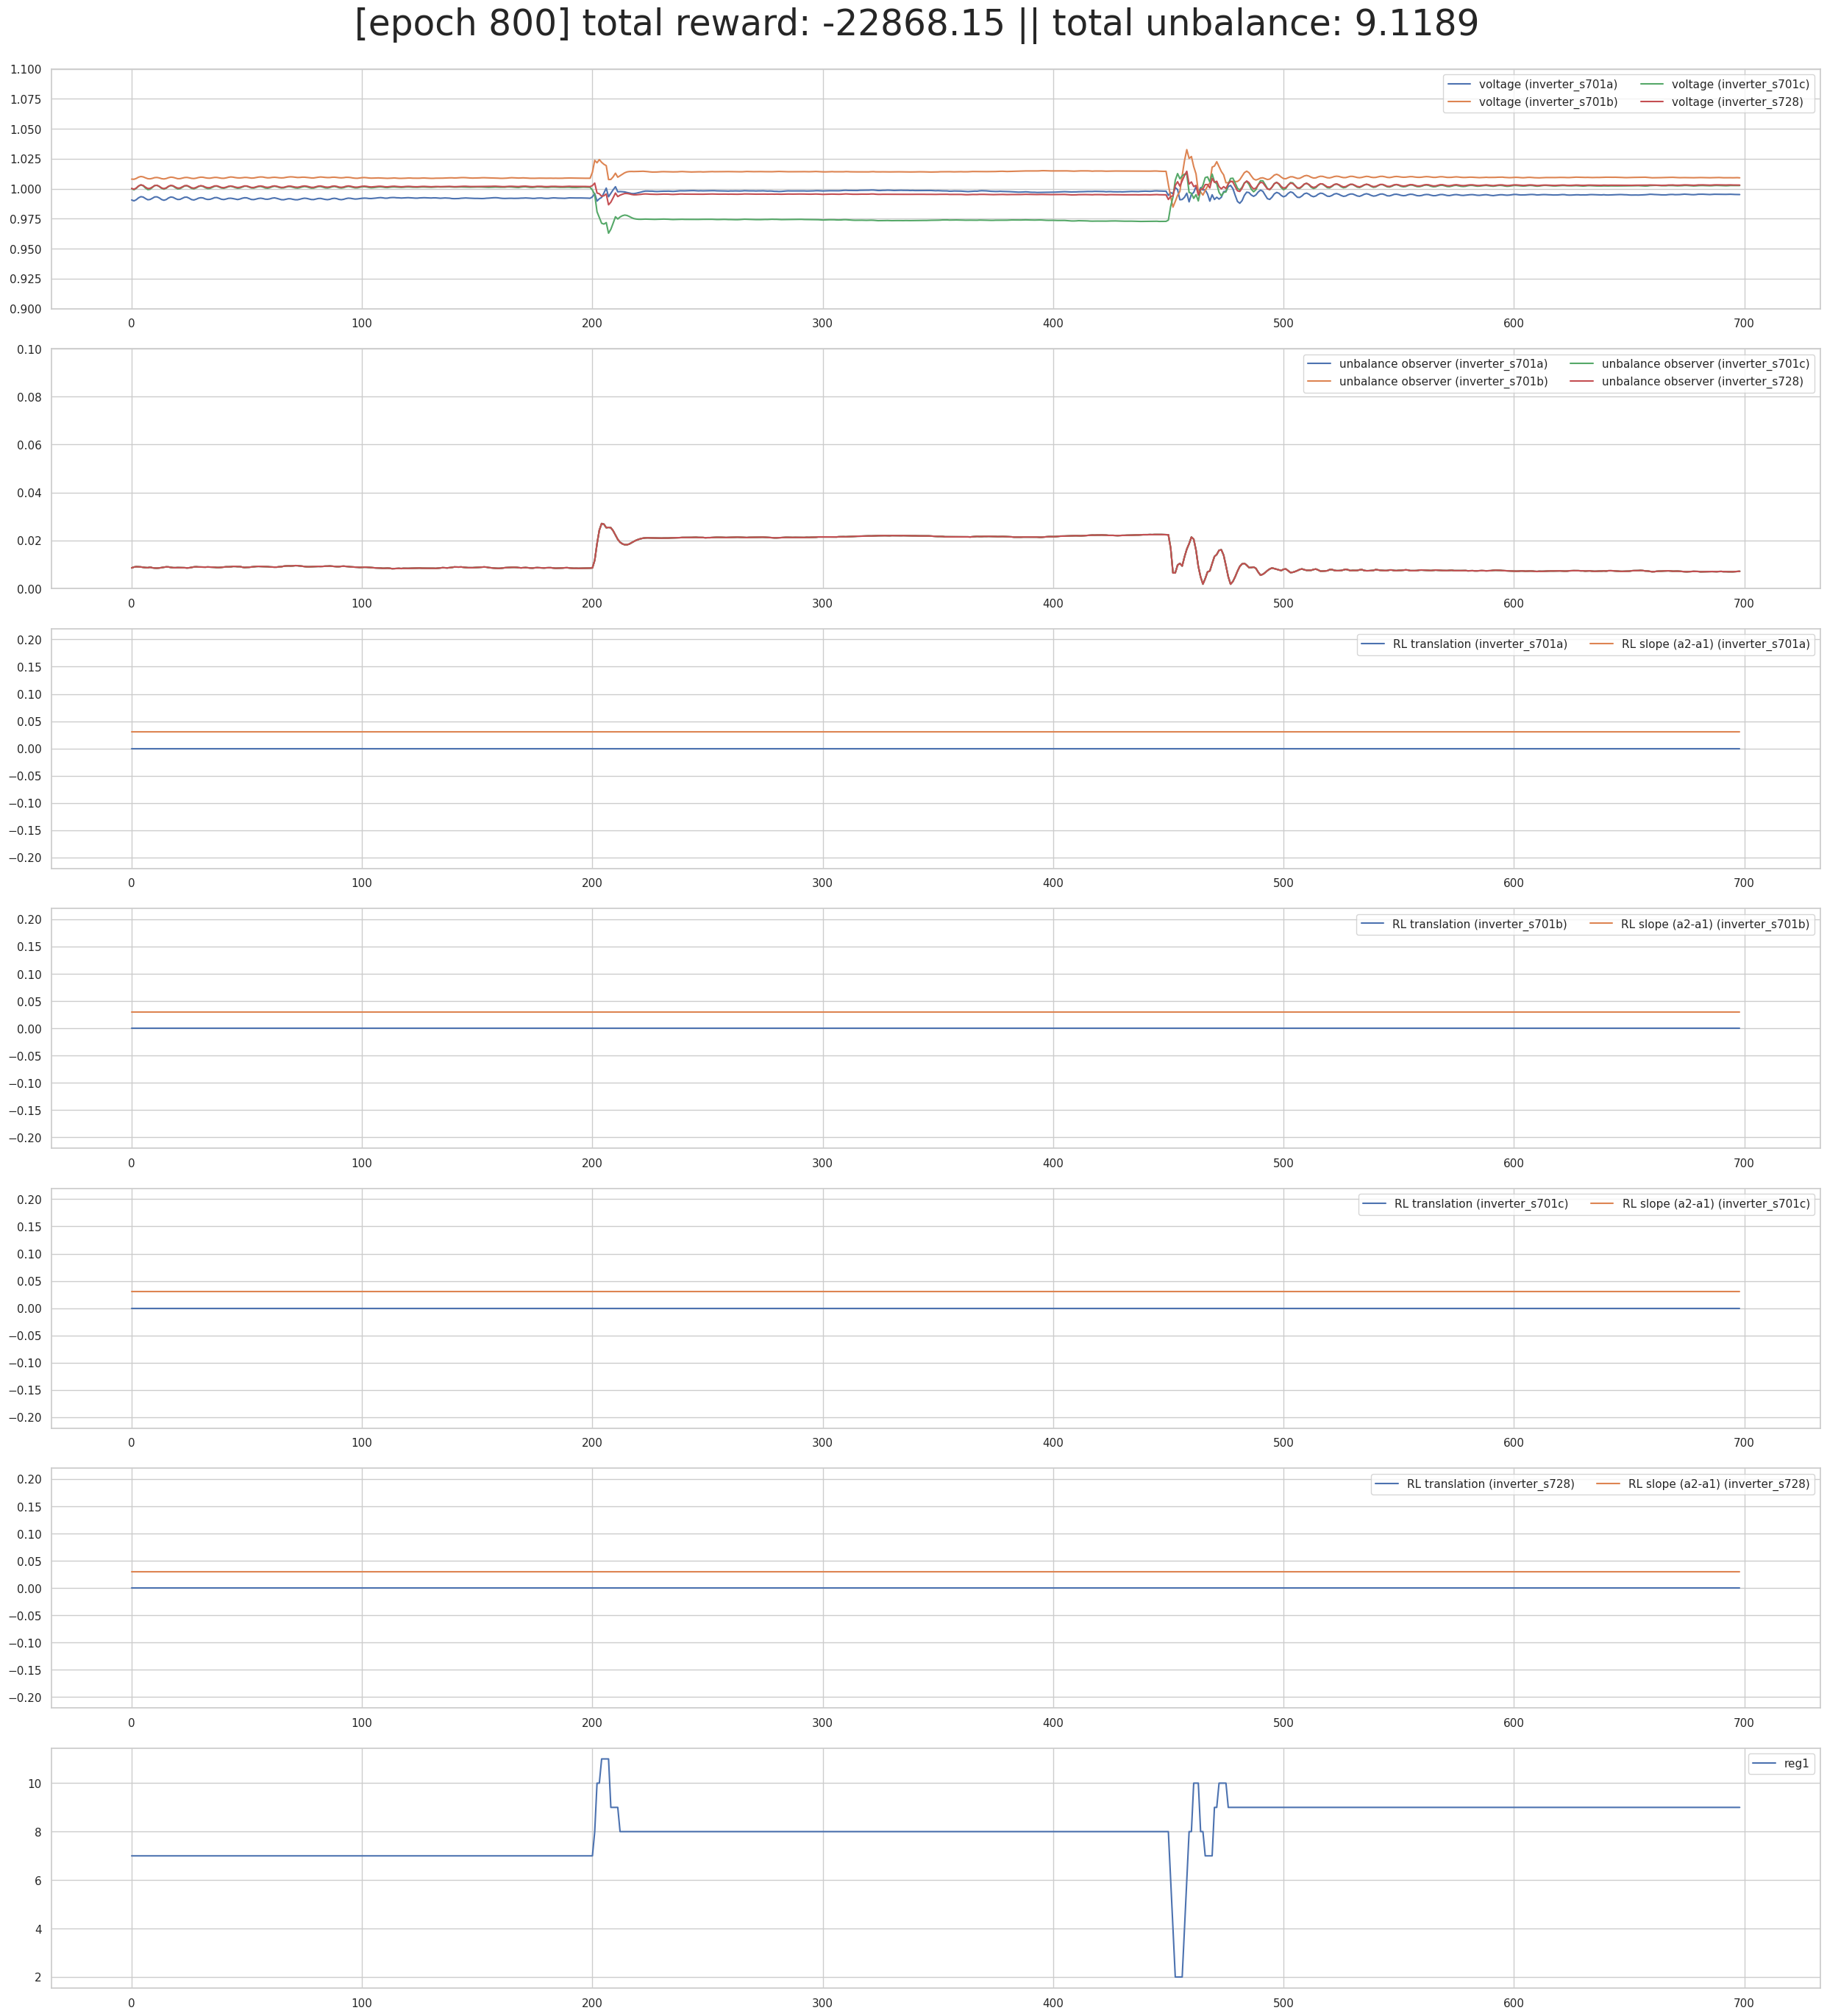

a


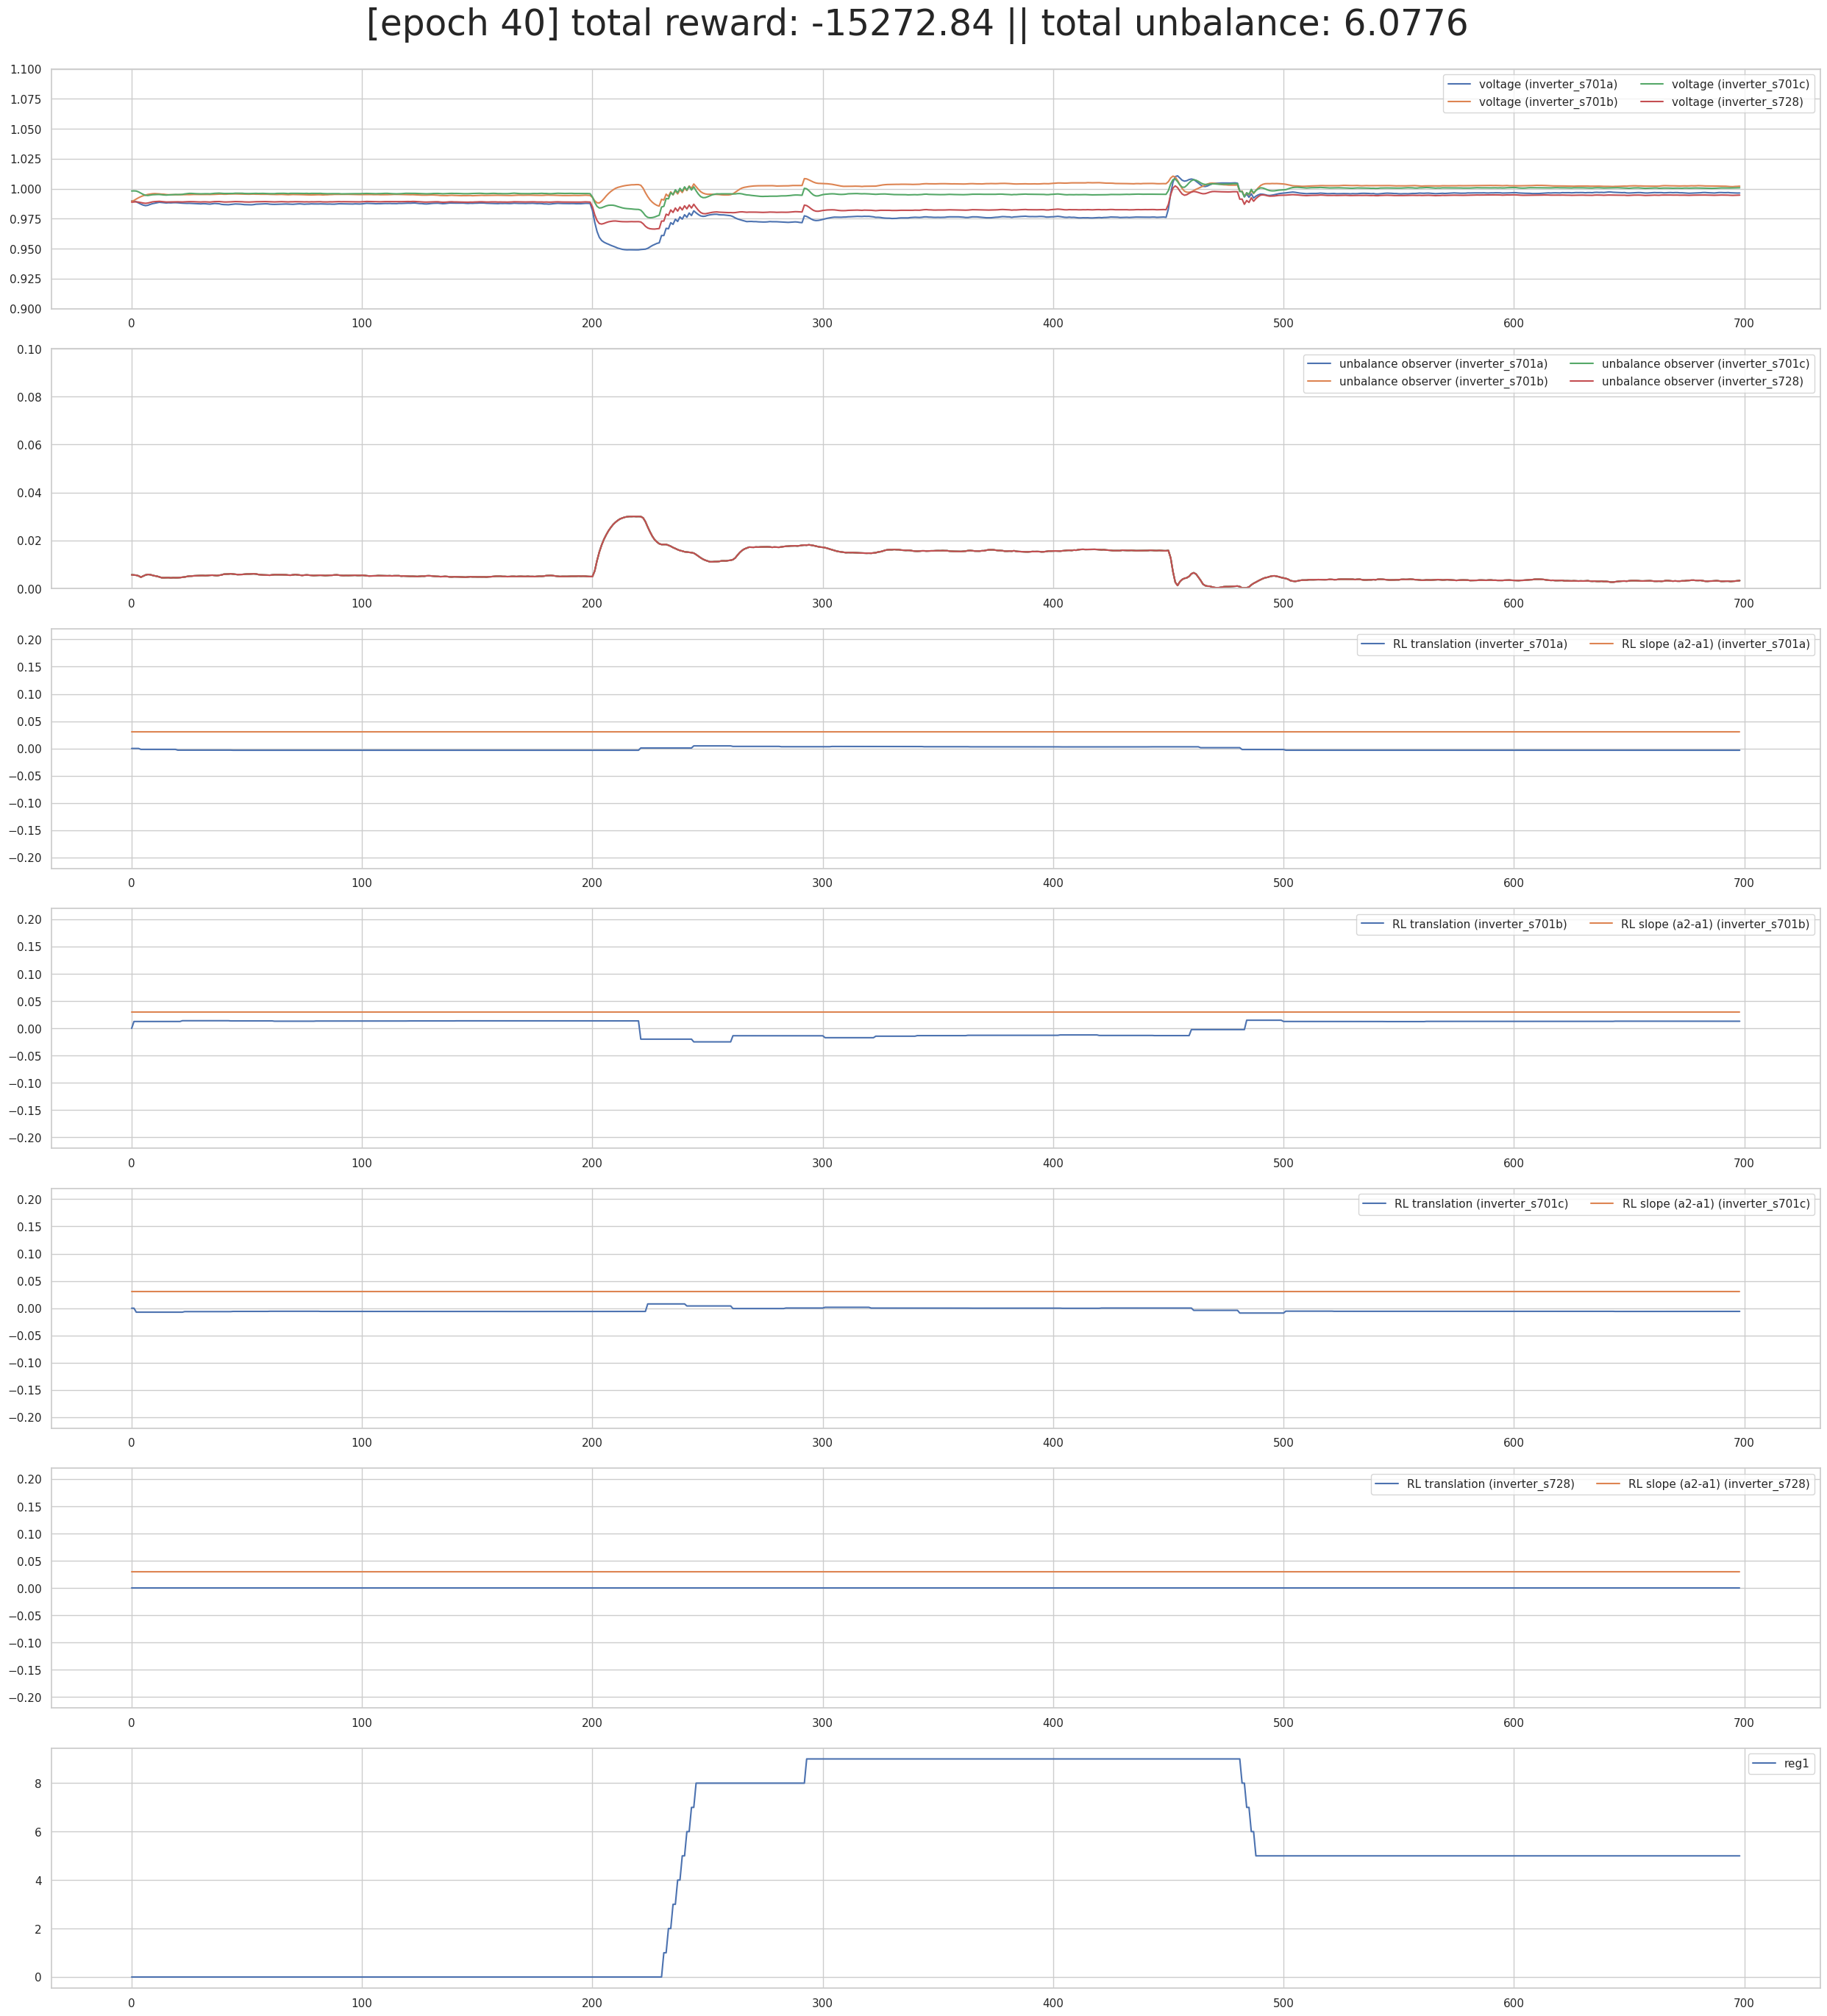

In [19]:
%matplotlib agg
%matplotlib agg

best_dir = Path('/home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_0_M=1000,M=1000,N=50,P=100_2020-06-23_08-35-33sqg4e1f9/best')
best_dir = Path('/home/alexandre/dev/LBL/lrc/PAPERNEWREGLAST/results_continuous_eval_30/main/run_train/run_train_0_M=50000,N=80,P=100_2020-08-14_07-49-27k4ale0i1/best/reward_sum')
infos = json.loads((best_dir / 'info.json').read_text())
policy = tf.saved_model.load(str(best_dir / f'policy'))
infer = policy.signatures['serving_default']

res = eval_dir_continuous(best_dir, 100, 0.3)
res['figure']

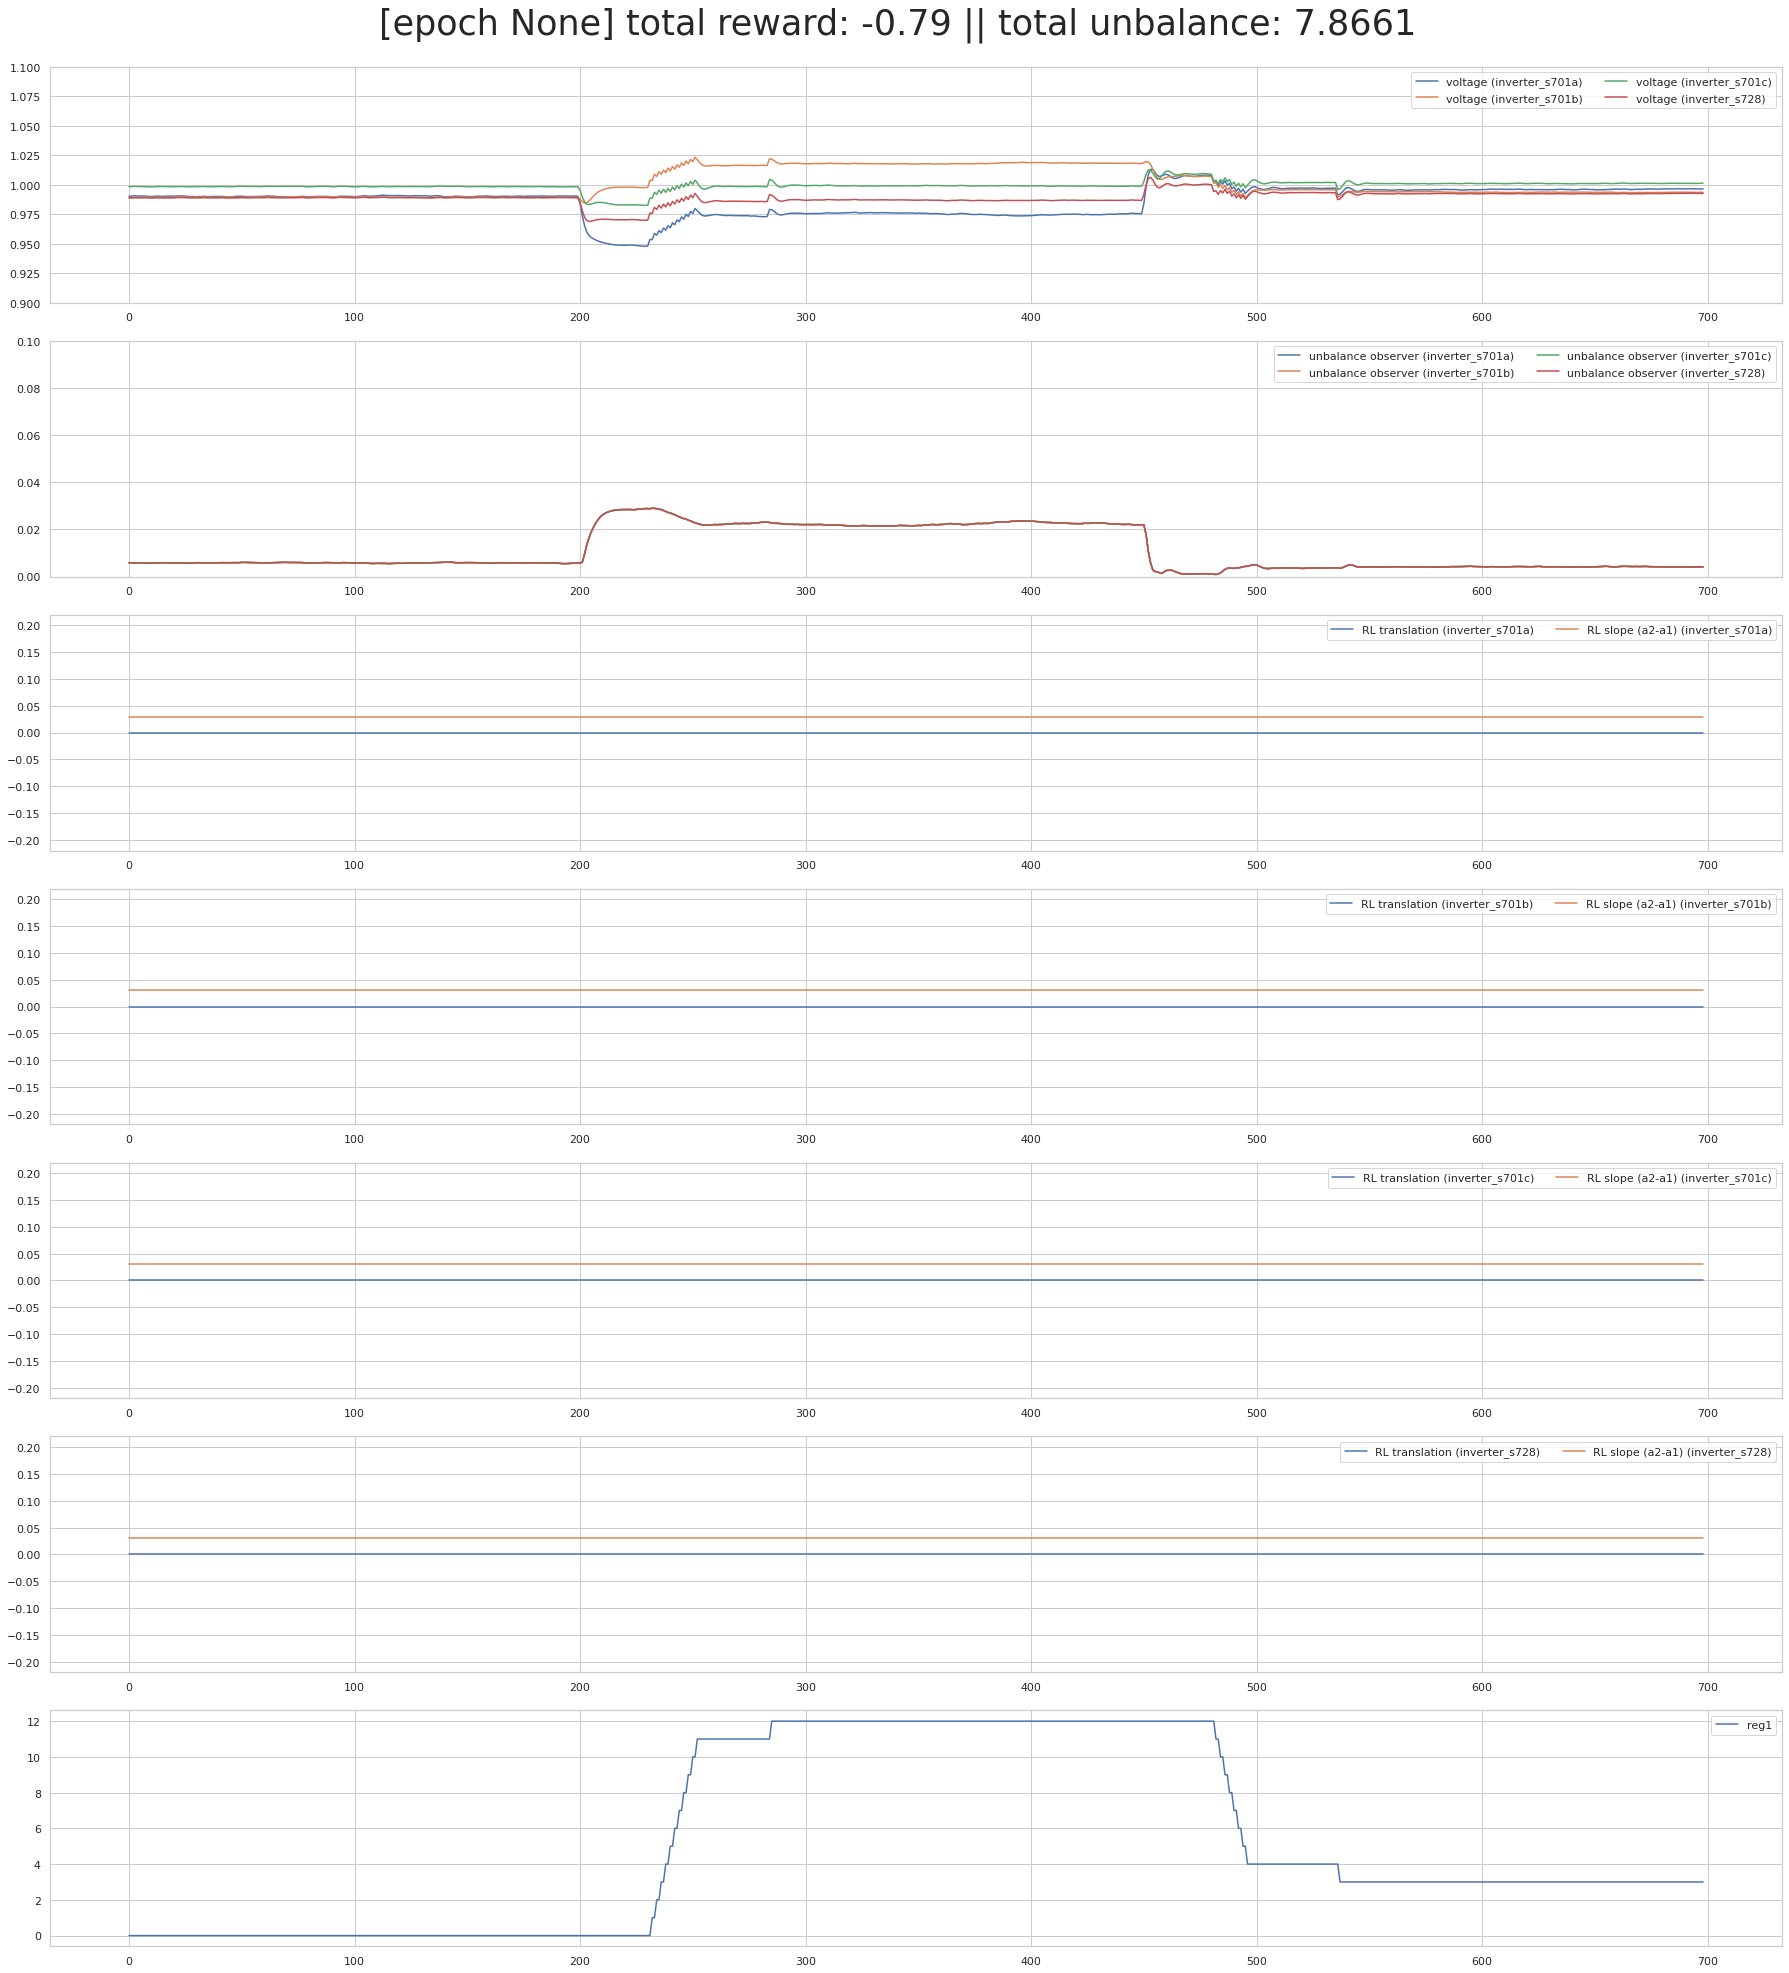

In [11]:
res = eval_baseline(eval_start=0, hack=0.30)
res['figure']

In [21]:
import opendssdirect as dss
dss.Solution.ControlMode()

-1

a


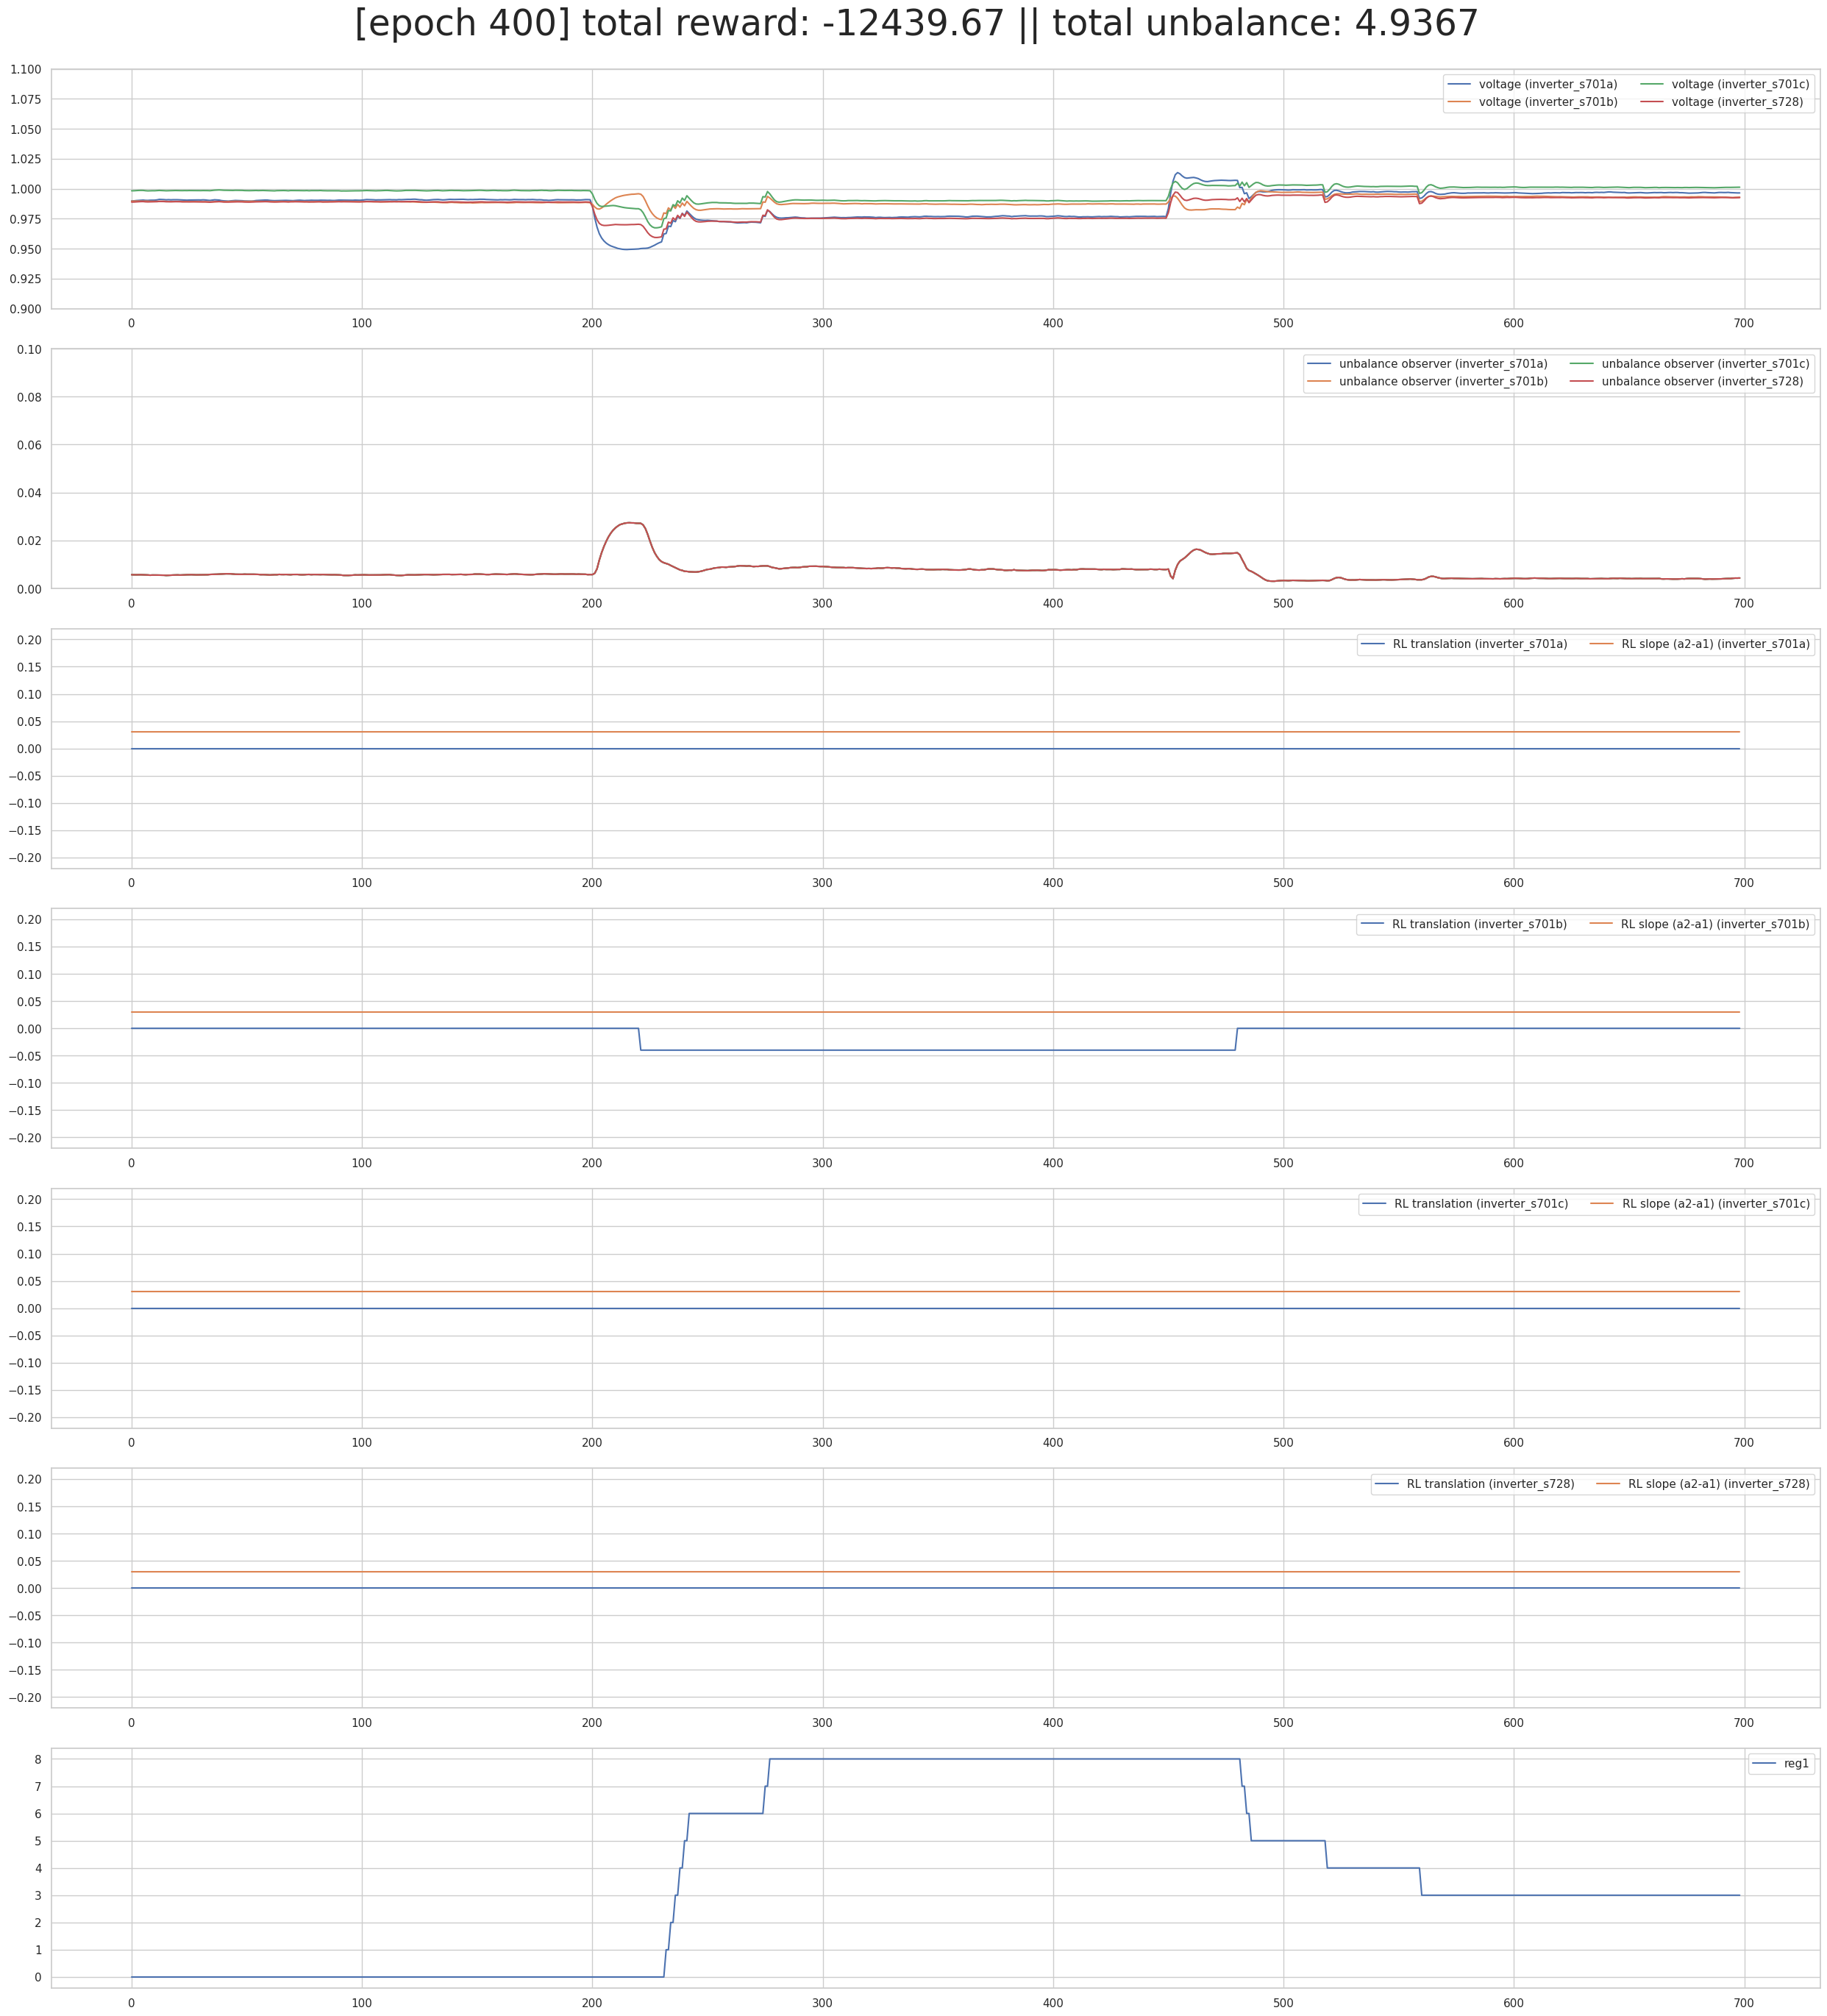

In [18]:
%matplotlib agg
%matplotlib agg

best_dir = Path('/mnt/hdd/dev/LBL/lrc/simple/results_discrete_eval/main/run_train/run_train_3_N=10,P=50,M=50000,N=10,P=50_2020-07-29_22-42-31j9q0fexv/best/neg_y_u_sum')
best_dir = Path('/mnt/hdd/dev/LBL/lrc/new_eval_3/results_discrete_eval/main/run_train/run_train_0_M=50000,N=50,P=50_2020-07-25_23-52-29a6t714nd/best/reward_sum')
best_dir = Path('/home/alexandre/dev/LBL/lrc/PAPERNEWREG/results_discrete_eval_30/main/run_train/run_train_0_M=50000,N=50,P=100_2020-08-11_19-22-3786x7kxmp/best/reward_sum')
policy = tf.saved_model.load(str(best_dir / f'policy_400'))
infer = policy.signatures['serving_default']
    
res = eval_dir_discrete(best_dir, 100, 0.3)
res['figure']

In [16]:
from pycigar.utils.logging import logger

log_dict = logger().log_dict

In [20]:
from pycigar.utils.logging import logger

def get_translation_and_slope(a_val, init_a):
    points = np.array(a_val)
    slope = points[:, 1] - points[:, 0]
    translation = points[:, 2] - init_a[2]
    return translation, slope

log_dict = logger().log_dict
custom_metrics = logger().custom_metrics

ta, _ = get_translation_and_slope(
                    log_dict['inverter_s701a']['control_setting'], custom_metrics['init_control_settings']['inverter_s701a']
                )
tb, _ = get_translation_and_slope(
                    log_dict['inverter_s701b']['control_setting'], custom_metrics['init_control_settings']['inverter_s701b']
                )
tc, _ = get_translation_and_slope(
                    log_dict['inverter_s701c']['control_setting'], custom_metrics['init_control_settings']['inverter_s701c']
                )
tall, _ = get_translation_and_slope(
                    log_dict['inverter_s728']['control_setting'], custom_metrics['init_control_settings']['inverter_s728']
                )
va = log_dict['s701a']['voltage']
vb = log_dict['s701b']['voltage']
vc = log_dict['s701c']['voltage']
u = log_dict['inverter_s701c']['u']
reg = log_dict['reg1']['tap_number']

import pandas as pd
df = pd.DataFrame({'va': va, 'vb': vb, 'vc': vc, 't_a': ta, 't_b': tb, 't_c': tc, 't_all': tall, 'u': u, 'ht_a': ta, 'ht_b': tb, 'ht_c': tc, 'ht_all': tall, 'reg': reg})
df.to_csv('continuous_h30_t0.csv', sep=',')

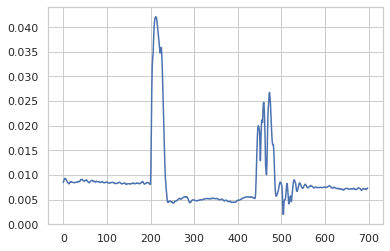

In [12]:
%matplotlib inline
df['u'].plot()
plt.show()

In [73]:
df = pd.read_csv('discrete_h60_t100.csv')

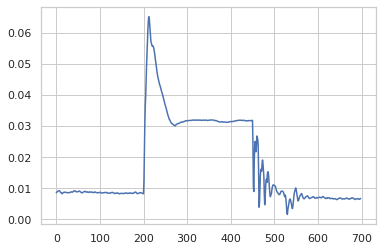

In [74]:
df['u'].plot()
plt.show()